In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

sns.set_style("ticks")
sns.set_context("talk")

# TODO: Add to requirements


**1) For both Smith-Waterman and Needleman-Wunsch algorithms:**
* **What are the parameters and variables required for algorithm initialization, execution, and termination?**  
    * Parameters are required for intialization are the opening/extension gap penalties and scoring matrices. 
* **What quantities are returned?**  
    * The optimal alignment for the intial query sequences, and a score for the alignment
* **What is the runtime complexity?**
    * The runtime complexity is O(mn), since it only requires traversal through an m x n matrix, where m and n are the lengths of the query sequences

**2) What functionalities in initialization, execution and termination are shared between these algorithms? Which are not shared?**
* **Shared**
    * Initialization of scoring matrix and gap penalties is shared
    * Calculating scores and storing pointers for backtracing is the same, with minor exceptions explained below
* **Not shared**
    * Initialization of the scoring and backtracing matrices is different (excluding the first row/col) - in NW, values are initially set to -inf and in SW, values are set to 0
    * Differences in scoring - in NW, negative values are allowed, but in SW, negative scores are clipped to 0
    * Differences in backtracing - This is where there are major differences. Since SW is a local alignment, backtracing starts from the highest score at any position in the matri(ces) and terminates when a negative score is reached. In NW, backtracing always starts from the bottom right corner and ends in the top left corner. 

**3) How does affine-gap based alignment differ from linear-gap alignment in terms of implementation?**  
In affine-gap alignment, scores for calling a match, opening a gap, or extending an existing gap are all considered when determining the optimal alignment, so multiple pointers that represent the possible cases must be stored for backtracking. In terms of implementation, this means that separate scores and pointers for each case (match, gap in seq 1, or gap in seq 2) need to be tracked. The scores and pointers may be stored in separate matrices (as in this implementation). In linear-gap alignment, there is no need to keep track of multiple scores/pointers, so one score matrix and one pointer matrix are sufficient. 

**4) Write out an API (methods, variables) with which a user could interact with your class.**  
* See below and also the rest of repository
    

In [45]:
class PairwiseAligner:
    '''
    Main parent class containing shared alignment functions and variables
        
    Params:
        scores_file (str): pathlike to .mat file with substitution matrix 

    Functions:
        read_scoring_file(str)
        create_scoring_dict(array)
        backtrace(str1, str2)
        
    '''
    
    def __init__( self, scoring_mat ):
        
        # init alignment and gap matrices
        self.align_mat = None
        self.gapA_mat = None
        self.gapB_mat = None
        
        # init backtrace matrices
        self.back = None
        self.back_A = None
        self.back_B = None
        
        # optimal score
        self.opt_score = 0
        
        # sequences
        self.seqA = ""
        self.seqB = ""
        
        # alignments
        self.seqA_align = ""
        self.seqB_align = ""
        
        # penalties
        self.D_open = -12
        self.D_extend = -2
        
        # read in scoring matrix and create scoring dictionary
        if isinstance(scoring_mat, str): 
            self.scoring_mat, self.alphabet = self.read_scoring_file(scoring_mat)
            self.scores_dict = self.init_scoring_dict()
        elif isinstance(scoring_mat, dict):
            self.scores_dict = scoring_mat
        else: 
            self.scoring_mat = None
            self.alphabet = None
            print("set scoring matrix and alphabet manually")
            
    
    def read_scoring_file(self, scores_file):
        
        """
        Reads in file containing scoring matrix
        
        Params:
          scores_file (str): pathlike to .mat file with substitution matrix 

        Returns:
          scores_mat (np.ndarray) : n x n substitution matrix
          alphabet (list) : list of n amino acids

        """
        
        # read in file for scoring matrix
        with open(scores_file, 'r') as f:
            scores_mat = [line for line in f.read().splitlines() if "#" not in line]
            
        # extract out header characters
        alphabet = [char for char in scores_mat[0] if " " not in char]
        scores_mat = scores_mat[1:]
        
        # create list with transition matrix values
        for i in range(len(scores_mat)):
            scores_mat[i] = [int(score) for score in scores_mat[i].split(" ") if len(score) > 0]
        
        # convert to nparray
        scores_mat = np.array(scores_mat)
        
        return scores_mat, alphabet

    def init_scoring_dict(self, scoring_mat=None, alphabet=None):
        """
        Read in scoring file and creating dictionary 
        
        Params:
          scores_mat (ndarray): matrix of substition scores with first line as header

        Returns:
          scores_dict (dict) : dict that maps tuple of amino acids to score ( (aa1, aa2) -> score )

        """
        
        # option to update scoring matrix
        if scoring_mat is not None: 
            self.scoring_mat = scoring_mat
        
        # option to update alphabet
        if alphabet is not None: 
            self.alphabet = alphabet
        
        # check scoring matrix type and create scoring dictionary
        scores_dict = {}
        if isinstance(self.scoring_mat, np.ndarray):
            
            # step through each character and add each pair to dict
            for i in range(len(self.alphabet)):
                for j in range(len(self.alphabet)): 
                    scores_dict[self.alphabet[i],self.alphabet[j]] = self.scoring_mat[i][j]    
                    
            return scores_dict

        return "Scoring matrix invalid"
    
    def clean_sequence(self, seq, ignore_errors=True):
        
        # check for alphabet
        if self.alphabet is None: 
            return "Error: add an alphabet"
        
        # check for alphabet
        seq = seq.upper()
        seq = "".join([i if i in self.alphabet else "!" for i in seq])
        
        # check for alphabet
        if "!" in seq:
            if ignore_errors: seq = seq.replace("!", "*")
            else: return "Error: Invalid characters in sequence"
        
        return seq
        
    def backtrace(self, i, j, curr_back):
        """
        TODO: docstring 
        
        Params:
          scores_mat (ndarray): matrix of substition scores with first line as header

        Returns:
          scores_dict (dict) : dict that maps tuple of amino acids to score ( (aa1, aa2) -> score )

        """

        # update the sequence
        # if pointing to M, match sequence and move diagonally
        if curr_back is self.back: 
            self.seqA_align = self.seqA[i-1] + self.seqA_align
            self.seqB_align = self.seqB[j-1] + self.seqB_align
            i -= 1
            j -= 1

        # if pointing to gapA, add a gap to sequence A,  
        # get current character in B, and move left
        elif curr_back is self.back_A:
            self.seqA_align = "-" + self.seqA_align
            self.seqB_align = self.seqB[j-1] + self.seqB_align
            j -= 1

        # if pointing to gapB, add a gap to sequence B and move up
        elif curr_back is self.back_B: 
            self.seqB_align = "-" + self.seqB_align
            self.seqA_align = self.seqA[i-1] + self.seqA_align
            i -= 1
            
        return i, j
    
    def align(self, seqA, seqB, sw=False):
        """
        Initialize variables.
        
        Params:
          seqA (string): first sequence
          seqB (string): second sequence

        Returns:
          (string, string, int): gapped version of seqA, gapped version of seqB, alignment score

        """
        # clean and store sequences
        self.seqA = self.clean_sequence(seqA)
        self.seqB = self.clean_sequence(seqB)
        
        # reset alignment
        self.seqA_align = ""
        self.seqB_align = ""
        
        # initialize first row of gapA and backtrace matrices
        # since once i is 0, only gaps can be added to A
        for j in range(self.gapA_mat.shape[1]): 
            self.gapA_mat[0][j] = self.D_open + j * self.D_extend
            self.back_A[0][j] = 1
            self.back[0][j] = 1 

        # initalize first col of gapB and back
        # since once j is 0, only gaps can be added to B
        for i in range(self.gapB_mat.shape[0]): 
            self.gapB_mat[i][0] = self.D_open + i * self.D_extend
            self.back_B[i][0] = 2
            self.back[i][0] = 2

        # initalize corner of align_mat
        self.align_mat[0][0] = 0 
        
        # begin heuristic with backtrace values stored as 
        # 0 = diag, 1 = left, 2 = up, 3 = end (sw only)
        for i in range(1, len(self.seqA) + 1): 
            for j in range(1, len(self.seqB) + 1):
                
                # update I(A) and I(A) backtrace matrix values to 
                # keep track of whether gaps should be added to seqA
                _currScores = [self.align_mat[i, j-1] + self.D_open, # open gap in seqA
                               self.gapA_mat[i, j-1] + self.D_extend] # extend gap in seqA
                    
                self.gapA_mat[i, j] = max(_currScores) #I(A) 
                self.back_A[i, j] = np.argmax(_currScores) #backtrace

                # update I(B) and I(B) backtrace matrix values to 
                # keep track of whether gaps should be added to seqB
                _currScores = [self.align_mat[i-1, j] + self.D_open, # open gap in seqB
                               -np.inf, # ignored
                               self.gapB_mat[i-1, j] + self.D_extend] # extend gap in seqB
        
                self.gapB_mat[i,j] = max(_currScores) #I(B) 
                self.back_B[i, j] = np.argmax(_currScores) #backtrace 
        
                # update M and M backtrace matrix values
                s = self.scores_dict[self.seqA[i-1], self.seqB[j-1]]
                
                _currScores = [self.align_mat[i-1, j-1] + s, #match (diag)
                               self.gapA_mat[i, j],  #gap seqA (left)
                               self.gapB_mat[i, j]]  #gap seqB (up)
                    
                self.align_mat[i,j] = max(_currScores) #M
                
                if sw and (max(_currScores) <= 0): 
                    self.back[i, j] = 3 #add marker for end for sw
                else:
                    self.back[i, j] = np.argmax(_currScores) #backtrace

class NeedlemanWunch(PairwiseAligner):

    def __init__( self, scoring_mat):
        PairwiseAligner.__init__(self, scoring_mat) 

    def align(self, seqA, seqB, score_only=False):

        """
        Perform Needleman-Wunch global alignment with affine gap scoring.
        
        Params:
          seqA (string): first sequence
          seqB (string): second sequence

        Returns:
          (string, string, int): gapped version of seqA, gapped version of seqB, alignment score

        """

        # create matrices for alignment scores and gaps 
        self.align_mat = np.ones((len(seqA) + 1, len(seqB) + 1)) * -np.inf
        self.gapA_mat = np.ones((len(seqA) + 1, len(seqB) + 1)) * -np.inf
        self.gapB_mat = np.ones((len(seqA) + 1, len(seqB) + 1)) * -np.inf

        # create matrices for backtracing pointers
        self.back = np.ones((len(seqA) + 1, len(seqB) + 1)) * -np.inf
        self.back_A = np.ones((len(seqA) + 1, len(seqB) + 1)) * -np.inf
        self.back_B = np.ones((len(seqA) + 1, len(seqB) + 1)) * -np.inf
        
        # initialize other variables with parent class align
        super(NeedlemanWunch, self).align(seqA, seqB, sw=False)
                
        return self.backtrace(score_only=score_only)
    
    def backtrace(self, score_only=False):
        # Use list to keep track of what the value of the backtrace matrix points to, with
        # the index corresponding to the pointers used (0=diag=M, 1=left=IA, 2=up=IB). 
        # This favors left pointers over up, so in the case of ties, the default is to
        # add a gap in sequence A, not B.
        all_mat = [self.align_mat, self.gapA_mat, self.gapB_mat]
        all_back = [self.back, self.back_A, self.back_B]
        
        # get pointer to matrix with largest optimal value
        mat_ind = np.argmax([self.align_mat[-1][-1], self.gapA_mat[-1][-1], self.gapB_mat[-1][-1]])
        
        # get matrix containing maximum score
        curr_mat = all_mat[mat_ind]
        curr_back = all_back[mat_ind]
        
        # get starting index
        i, j = curr_mat.shape[0] - 1, curr_mat.shape[1] - 1
        
        # update the optimal score
        self.opt_score = int(curr_mat[i][j])
        
        # return the optimal score if no traceback is necessary
        if score_only: return self.opt_score
        
        # begin backtracing
        while (i > 0 or j > 0):
            
            # store current pointer
            pointer = curr_back[i, j]
            
            # use parent backtrack function
            i, j = super(NeedlemanWunch, self).backtrace(i, j, curr_back)
        
            # use pointer to select next backtrace matrix
            curr_back = all_back[int(pointer)]
        
        # return the alignments and score
        return (self.seqA_align, self.seqB_align, self.opt_score)
    
class SmithWaterman(PairwiseAligner):

    def __init__( self, scoring_mat):
        PairwiseAligner.__init__(self, scoring_mat) 

    def align(self, seqA, seqB, score_only=False):

        """
        Perform Needleman-Wunch global alignment with affine gap scoring.
        
        Params:
          seqA (string): first sequence
          seqB (string): second sequence

        Returns:
          (string, string, int): gapped version of seqA, gapped version of seqB, alignment score

        """

        # create matrices for alignment scores and gaps 
        self.align_mat = np.zeros((len(seqA) + 1, len(seqB) + 1))
        self.gapA_mat = np.zeros((len(seqA) + 1, len(seqB) + 1))
        self.gapB_mat = np.zeros((len(seqA) + 1, len(seqB) + 1))

        # create matrices for backtracing pointers
        self.back = np.zeros((len(seqA) + 1, len(seqB) + 1))
        self.back_A = np.zeros((len(seqA) + 1, len(seqB) + 1))
        self.back_B = np.zeros((len(seqA) + 1, len(seqB) + 1))
        
        # initialize other variables with parent class align
        super(SmithWaterman, self).align(seqA, seqB, sw=True)
                
        #self.sanity_check()
        return self.backtrace(score_only)
    
    def backtrace(self, score_only=False):
        """
        TODO: documentation
        
        Params:
          seqA (string): first sequence
          seqB (string): second sequence

        Returns:
          (string, string, int): gapped version of seqA, gapped version of seqB, alignment score

        """
        # Use list to keep track of what the value of the backtrace matrix points to, with
        # the index corresponding to the pointers used (0=diag=M, 1=left=IA, 2=up=IB). 
        # This favors left pointers over up, so in the case of ties, the default is to
        # add a gap in sequence A, not B.
        all_mat = [self.align_mat, self.gapA_mat, self.gapB_mat]
        all_back = [self.back, self.back_A, self.back_B]
        
        # get pointer to matrix with largest optimal value
        mat_ind = np.argmax([np.max(self.align_mat), np.max(self.gapA_mat), np.max(self.gapB_mat)])
        
        # get matrix containing maximum score
        curr_mat = all_mat[mat_ind]
        curr_back = all_back[mat_ind]
        
        # get index of largest value
        max_ind = np.where(curr_mat == np.amax(curr_mat))
        i, j = max_ind[0][0], max_ind[1][0]
        
        # update the optimal score using the largest value
        self.opt_score = int(curr_mat[i][j])
        
        # return optimal score if traceback is not necessary
        if score_only: return self.opt_score
        
        # begin backtracing
        while (i > 0 and j > 0) and (curr_back[i,j] < 3):
            
            # store current pointer
            pointer = curr_back[i, j]
            
            # use parent backtrack function
            i, j = super(SmithWaterman, self).backtrace(i, j, curr_back)
            
            # use pointer to select next backtrace matrix
            curr_back = all_back[int(pointer)]
        
        # return the alignments and score
        return (self.seqA_align, self.seqB_align, self.opt_score)


# input fasta files of alignments
def read_fasta(input_file):
    with open(input_file, 'r') as f:
        fasta = [line for line in f.read().splitlines()]
        return fasta[0], "".join(fasta[1:])
    

In [5]:
nw = NeedlemanWunch("./scoring_matrices/BLOSUM62.mat")
nw.align("AAT", "ACACT")

sw = SmithWaterman("./scoring_matrices/BLOSUM62.mat")
sw.align("AAT", "ACACT")


('AAT', 'ACT', 9)

**1) With the BLOSUM50 matrix and a gap opening cost of 11 and a gap extension cost of 3, locally align these sequences and visualize the distribution of alignment scores. How would you describe this distribution?**
* The distribution is skewed to the right, with most scores below 50 and a few alignments with very high scores. These outliers were all "true positive" pairs as expected, and the high scores indicate that there were queries with highly conserved sequences that aligned well with each other. 
* Also since this is Smith-Waterman, all the optimal scores are positive or 0



<AxesSubplot:xlabel='score', ylabel='Count'>

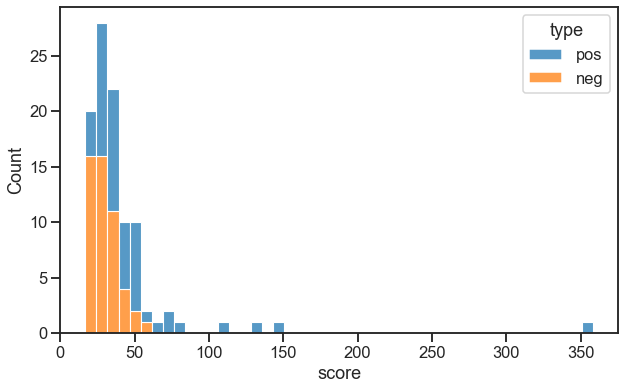

In [44]:
# directory
directory = "./"

# read in BLOSUM50 matrix
sw = SmithWaterman(directory + "scoring_matrices/BLOSUM50.mat")

# set gap penalties
sw.D_open = -11
sw.D_extend = -3

# read in files with positive and negative pairs
pos_file = directory + "scoring_matrices/Pospairs.txt"
neg_file = directory + "scoring_matrices/Negpairs.txt"

pos_seq = pd.read_csv(pos_file, delimiter=" ", header=None, names=["file1", "file2"])
neg_seq = pd.read_csv(neg_file, delimiter=" ", header=None, names=["file1", "file2"])

# merge positive and negative dataframes
pos_seq["type"] = "pos"
neg_seq["type"] = "neg"

fasta_df = pos_seq.append(neg_seq)
fasta_df = fasta_df.reset_index(drop=True)

# empty dictionaries for storing data
fasta_dict = {}
scores_dict = {}

# NOTE: takes a while so run only once to get scores for all sequences
for ind in fasta_df.index: 
    file1, file2 = directory + fasta_df.iloc[ind]["file1"], directory + fasta_df.iloc[ind]["file2"]
    
    # store protein data
    fasta_dict[file1] = read_fasta(file1)
    fasta_dict[file2] = read_fasta(file2)
    
    # get scores
    scores_dict[ind] = sw.align(fasta_dict[file1][1], fasta_dict[file2][1])

scores_df = pd.DataFrame.from_dict(scores_dict, orient="index")
scores_df.columns = ["seq1", "seq2", "score"]

# merge alignment data to file data
out_file = "./output/Q2-1_pair_scores.csv"
fasta_df = fasta_df.merge(scores_df, how="inner", left_index=True, right_index=True)
fasta_df.to_csv(out_file)

# plot distribution
input_file = "./output/Q2-1_pair_scores.csv"
fasta_df = pd.read_csv(input_file, index_col=0)
plt.rcParams['figure.figsize']=(10,6)
sns.histplot(data=fasta_df, x="score", hue="type", multiple="stack")



**2) Generate a confusion matrix indicating the frequency of false positives, false negatives, true positives, and true negatives when using the average alignment score as a threshold. What is the threshold value, and how does the confusion matrix suggest this algorithm performed?**
* The average score that was used for the threhold was 40.19
* The confusion matrix is stored in a dataframe below, with TN = 45, FP = 5, FN = 27, TP = 23  


* Sensitivity = 0.46
* Specificity = 0.9 


Calculations for sensitivity and specificity are shown in the cell below. The specificity is high (close to 1) so the algorithm is good at predicting true negative values. The sensitivity is lower, indicating that the algorithm is not as good at predicting true positives, and returns a false negative value in 100% * (1 - 0.46) = 64% of positive test cases. 




In [7]:
# get the average score to be used as the threshold
avg = np.mean(fasta_df["score"])
print("Average score = %s"%avg)

# identify true/false positives/negatives 
fasta_df["called"] = ["pos" if score > avg else "neg" for score in fasta_df["score"]]
fasta_df["confusion"] = fasta_df["type"]  + fasta_df["called"] 
fasta_df["confusion"] = ["TN" if "negneg" in line
                        else "FP" if "negpos" in line
                        else "TP" if "pospos" in line
                        else "FN" for line in fasta_df["confusion"]]

# create confusion matrix
values = fasta_df["confusion"].value_counts()
TN = values["TN"]
FP = values["FP"]
FN = values["FN"]
TP = values["TP"]
confusion_mat = [[TN, FP, (TN+FP)], [FN, TP, (FN+TP)], [(TN+FN), (TP+FP), (TP+FP+TN+FN)]]

# print values and show confusion matrix
print("Sensitivity = %s"%(TP / (TP + FN)))
print("Specificity = %s"%(TN / (TN + FP)))

pd.DataFrame(confusion_mat, index=["True -", "True +", "Total"], columns=["Predicted -", "Predicted +", "Total"])



Average score = 40.19
Sensitivity = 0.46
Specificity = 0.9


,Predicted -,Predicted +,Total
True -,45,5,50
True +,27,23,50
Total,72,28,100


**3) Create a ROC plot which shows the fraction of true positives on the Y axis and the fraction of false positives on the X axis. Please take care to make your ROC plots square, with both X and Y axes limited to the range [0:1]**
* See ROC curve below

**4) Determine the area under the ROC curve (AUROC). What does this value indicate about the performance of this algorithm? Can you confidently assess the performance of this algorithm with this value alone? Why or why not?**
* Since the AUROC (=0.74) is greater than 0.5, the algorithm performs better than a random classifier.
* The closer the value of the AUROC is to 1, the better the algorithm is in classifying true positives and true negatives. 
* However, this number does not provide a complete picture about the performance of this algorithm, since it does not provide any information about the actual specificity or sensitivity values at any particular threshold (even if those values go into the calculation of the AUROC). Some algorithms may require better sensitivity while others may require better specificity, and the AUROC value alone cannot be used to determine whether the algorithm is suitable for each particular use case.




In [72]:
def plot_roc(fpr, tpr, roc_auc, label = "", title=""):
    # adapted from scikit learn example to plot ROC curve
    # https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
    plt.figure(figsize=(8,8))
    if label == "": label = 'ROC curve (area = %0.2f)' % roc_auc
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=label)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

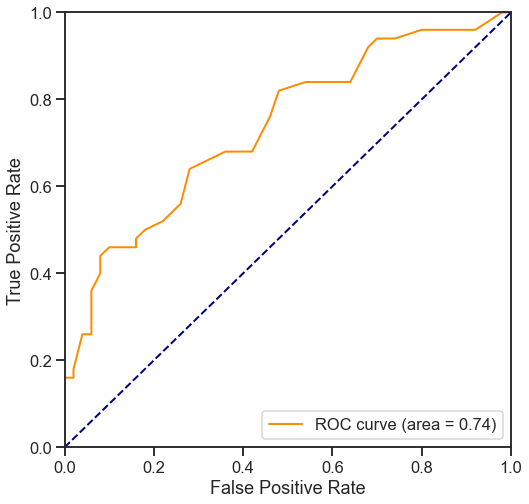

In [73]:
# use scikit packages to calculate values in ROC curve and AUROC
fpr, tpr, thresholds = metrics.roc_curve(y_true=fasta_df["type"], y_score=fasta_df["score"], pos_label="pos")
roc_auc = metrics.auc(fpr, tpr)

# plot values
plot_roc(fpr, tpr, roc_auc)


**Q5) Once again, using local alignment, try a range of gap opening (1-20) and gap extension (1-5) costs with the BLOSUM62 matrix. Using the AUROC of each approach, determine which gap penalty performs the “best”. What does this pair of values suggest about the evolution of these sequences and the likelihood of insertions / deletions?**
* Best AUROC = 0.8304
* Although there were several gap pairs that had an AUROC equal to 0.8304, the one I will be using as the best pair are D_open=6 and D_ext=1 (in my implementation, these are used as -6 and -1)
* Having a high gap opening penalty relative to the extension penalty means that gaps should only opened if necesary and extended when possible, suggesting that the likelihood of multiple insertions/deletions in these sequences is low.



In [ ]:
# directory
directory = "./"

# read in BLOSUM62 matrix
sw = SmithWaterman(directory + "scoring_matrices/BLOSUM62.mat")

# read in fasta_df
input_file = "./output/Q2-1_pair_scores.csv"
fasta_df = pd.read_csv(input_file, index_col=0)

# keep track of values
gap_scores_dict = {}
best_score = 0
best_open = 1
best_ext = 1

# for storing data
line = {}

# run algorithm for multiple gap open/extension penalties
for D_open in range(1,21):
    print(D_open)
    for D_ext in range(1,6):
        # update the penalties
        sw.D_open = -D_open
        sw.D_ext = -D_ext
            
        for ind in fasta_df.index:
            
            # update the query sequences
            file1 = directory + fasta_df.iloc[ind]["file1"]
            file2 = directory + fasta_df.iloc[ind]["file2"]
            
            # get alignment score
            score = sw.align(fasta_dict[file1][1], fasta_dict[file2][1], score_only=True)
            
            # store value
            line[(ind, sw.D_open, sw.D_ext)] = (file1, file2, score, fasta_df.iloc[ind]["type"])

# save values to file for easy access
lines_df = pd.DataFrame.from_dict(line, orient="index")
lines_df[['ind', 'D_open', 'D_ext']] = pd.DataFrame(lines_df.index.tolist(), index=lines_df.index)  
lines_df = lines_df.reset_index(drop=True)
lines_df.columns = ["file1", "file2", "score", "type", "ind", "D_open", "D_ext"]
lines_df.to_csv("./output/Q2-5_values.csv")

            

0.7454 1 2
0.7454 1 3
0.7454 1 4
0.7454 1 5
0.7776 2 2
0.7776 2 3
0.7776 2 4
0.7776 2 5
0.7942000000000001 3 2
0.7942000000000001 3 3
0.7942000000000001 3 4
0.7942000000000001 3 5
0.8184 4 2
0.8184 4 3
0.8184 4 4
0.8184 4 5
0.8288 5 2
0.8288 5 3
0.8288 5 4
0.8288 5 5
0.8304 6 2
0.8304 6 3
0.8304 6 4
0.8304 6 5
Best auroc=0.8304, D_open=6, D_ext=1


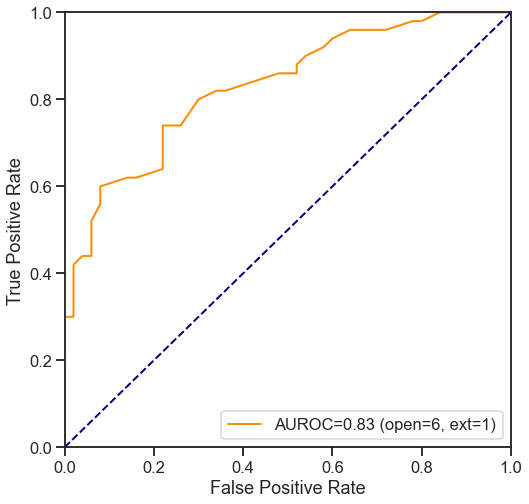

In [37]:
# read in the scores file previously generated
scores_df = pd.read_csv("./output/Q2-5_values.csv")

# store best score
best_auroc = 0
best_open = 0
best_ext = 0

# for each pair of open/extension penalties
for D_open in range(1,21):
    for D_ext in range(1,6):
        # segment dataframe to correct values
        curr_df = scores_df[scores_df["D_open"] == -D_open]
        curr_df = curr_df[curr_df["D_ext"] == -D_ext]
        
        # use scikit packages to calculate values in ROC curve and AUROC
        fpr, tpr, thresholds = metrics.roc_curve(y_true=curr_df["type"], y_score=curr_df["score"], pos_label="pos")
        roc_auc = metrics.auc(fpr, tpr)
        
        # update values
        if roc_auc > best_auroc:
            best_auroc = roc_auc
            best_open = D_open
            best_ext = D_ext
        elif roc_auc == best_auroc:
            print(best_auroc, D_open, D_ext)

        # plot values
        #plot_roc(fpr, tpr, roc_auc, label = "AUROC=%0.2f"%roc_auc+" (open=%s, ext=%s)"%(D_open,D_ext))
        
print("Best auroc=%s, D_open=%s, D_ext=%s"%(best_auroc, best_open, best_ext))

# Plot the ROC curve for the best set of gap penalties
curr_df = scores_df[scores_df["D_open"] == -best_open]
curr_df = curr_df[curr_df["D_ext"] == -best_ext]
fpr, tpr, thresholds = metrics.roc_curve(y_true=curr_df["type"], y_score=curr_df["score"], pos_label="pos")
plot_roc(fpr, tpr, best_auroc, label = "AUROC=%0.2f"%best_auroc+" (open=%s, ext=%s)"%(best_open,best_ext))



**6) Using the BLOSUM50, BLOSUM62, PAM100 and PAM250 scoring matrices, evaluate the performance of the global alignment algorithm using the selected pair of best performing gap penalties.**
* See code in cell below

**7) For each algorithm, generate a ROC plot demonstrating performance using each of the 4 matrices, given the fixed gap costs. Of all these algorithms, which performs the best as measured by AUROC?**   

The AUROC scores for each algorithm (using D_open=6, D_extend=1) were:

NW
* PAM100 = 0.77
* BLOSUM62 = 0.79
* BLOSUM50 = 0.83
* PAM250 = 0.83

SW
* PAM250 = 0.80
* BLOSUM50 = 0.81
* BLOSUM62 = 0.83
* PAM100 = 0.84

The best algorithm used the PAM100 matrix with Smith-Waterman alignment. The best global alignment was a tie between using the PAM250 and BLOSUM50.

**8) Comment qualitatively on the best algorithm. What does the best performing algorithm indicate about the origin of these sequences?**
* The best algorithm was PAM100 Smith-Waterman. Since local alignment performed better, this could suggest that the differences between positive and negative pairs was primarily based on specific domains, not the sequences as a whole.
* PAM matrices appeared at the top for both alignment methods, indicating that the sequences may have been from evolutionarily related proteins, since those were used to create the PAM matrices. Additionally, the PAM100 worked best for SW and PAM250 was the worst, and vice versa in NW. This makes sense, since PAM100 should be better at detecting more homologous sequences since it models a divergence of 1x (as opposed to a larger divergence of 2.5 by PAM250).




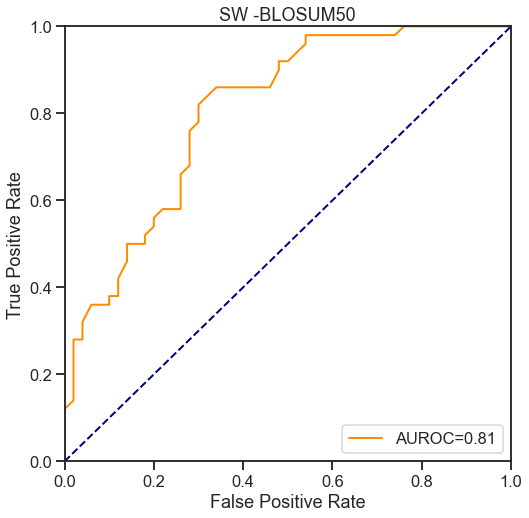

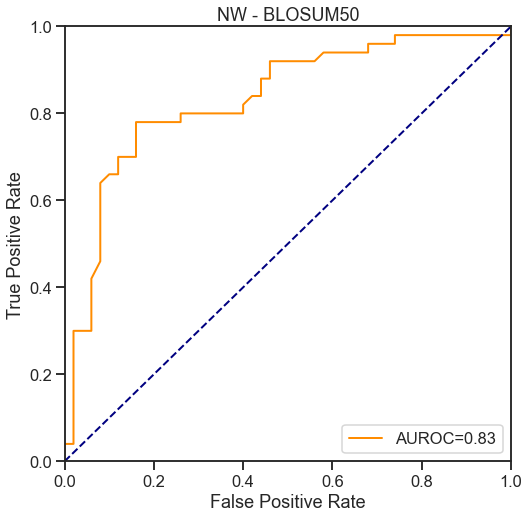

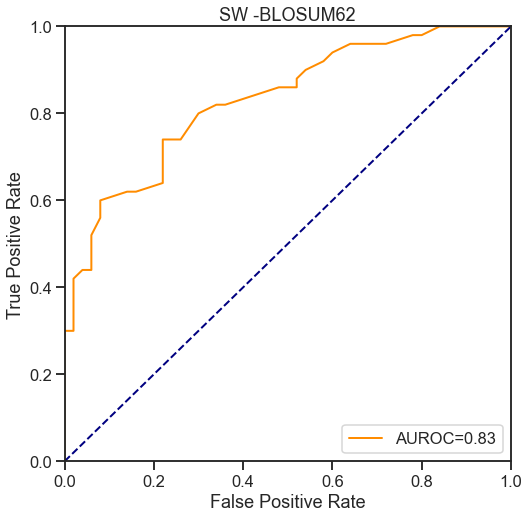

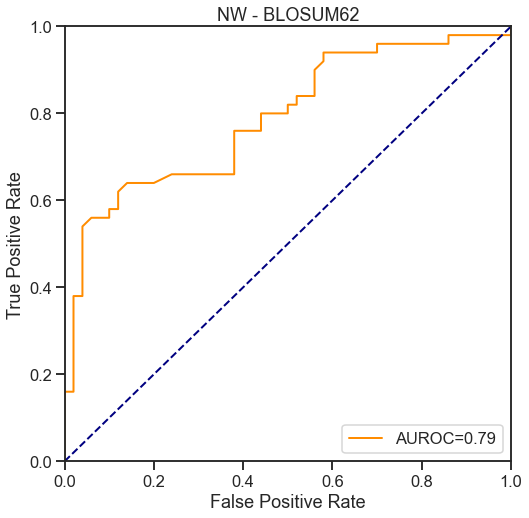

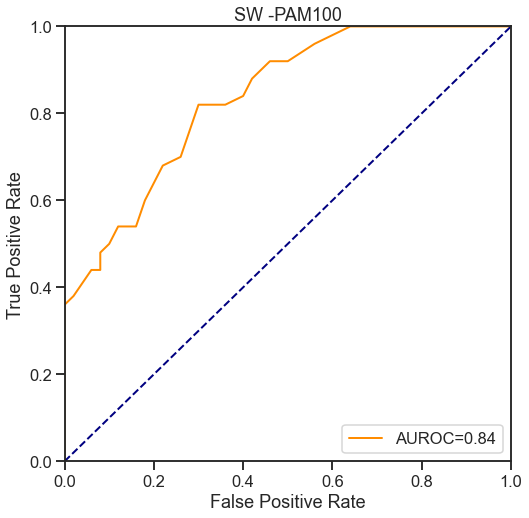

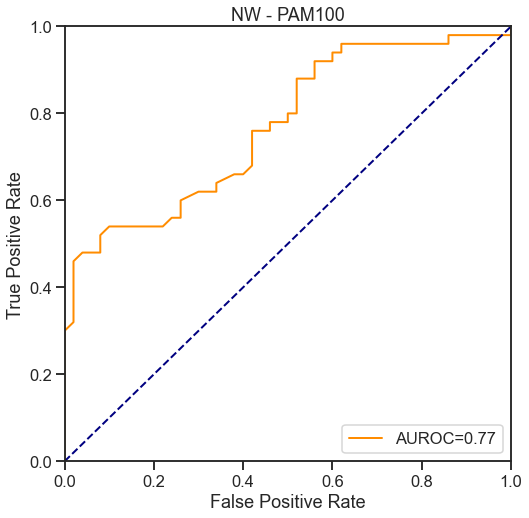

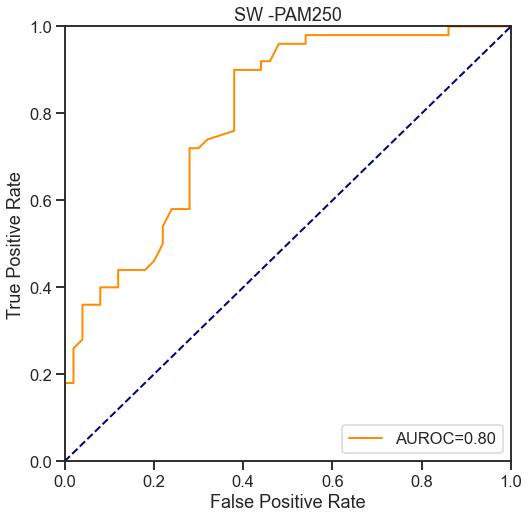

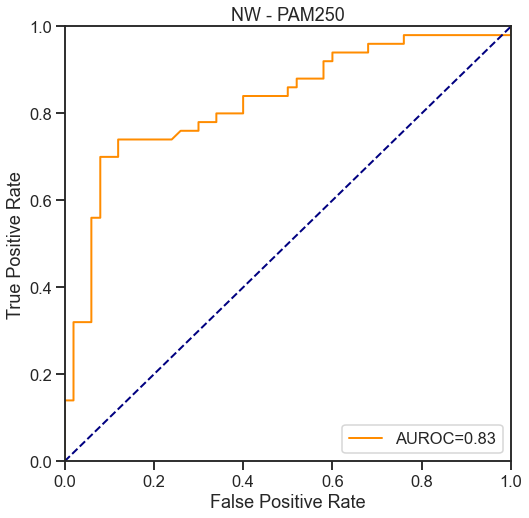

In [78]:
# directory
directory = "./"

# params
matrices = ["BLOSUM50", "BLOSUM62", "PAM100", "PAM250"]
D_open = -6
D_ext = -1

# read in fasta_df which contains information about file for each pair
input_file = directory+"output/Q2-1_pair_scores.csv"
fasta_df = pd.read_csv(input_file, index_col=0)

# empty dataframe for storing values
scores_df = pd.DataFrame()

# start for loop of all matrices
for matrix in matrices:
    
    # read in the correct matrix
    nw = NeedlemanWunch(directory+"scoring_matrices/%s.mat"%matrix)
    sw = SmithWaterman(directory+"scoring_matrices/%s.mat"%matrix)

    # use best performing gap penalties
    nw.D_open = D_open
    nw.D_ext = D_ext
    sw.D_open = D_open
    sw.D_ext = D_ext
    
    # create empty dictionary for storing current scores
    curr_scores_dict = {}
    
    # New for-loop for all fasta sequences. Uses the fasta_dict 
    # created in Q1 to quickly retrieve sequence information
    for ind in fasta_df.index:
        # get current sequence information
        file1 = directory+fasta_df.iloc[ind]["file1"]
        file2 = directory+fasta_df.iloc[ind]["file2"]
        truth = fasta_df.iloc[ind]["type"]
        
        # score sequence alignment using NW
        nw_score = nw.align(fasta_dict[file1][1], fasta_dict[file2][1], score_only=True)
        sw_score = sw.align(fasta_dict[file1][1], fasta_dict[file2][1], score_only=True)
    
        # store score in dictionary
        curr_scores_dict[ind] = (file1, file2, nw_score, sw_score, truth)
        
    curr_df = pd.DataFrame.from_dict(curr_scores_dict, orient="index")
    curr_df.columns = ["file1", "file2", "nw_score", "sw_score", "type"]
    curr_df["matrix"] = matrix
    scores_df = scores_df.append(curr_df)
    
    # plot 
    fpr, tpr, thresholds = metrics.roc_curve(y_true=curr_df["type"], y_score=curr_df["sw_score"], pos_label="pos")
    roc_auc = metrics.auc(fpr, tpr)
    plot_roc(fpr, tpr, roc_auc, label = "AUROC=%0.2f"%roc_auc, title="SW - " + matrix)
    
    fpr, tpr, thresholds = metrics.roc_curve(y_true=curr_df["type"], y_score=curr_df["nw_score"], pos_label="pos")
    roc_auc = metrics.auc(fpr, tpr)
    plot_roc(fpr, tpr, roc_auc, label = "AUROC=%0.2f"%roc_auc, title="NW - " + matrix)

scores_df.to_csv(directory+"output/Q2-6_scores.csv")

